In [55]:
import pandas as pd
data = pd.read_csv("clinvar_final2.tsv", 
                  
                 sep='\t', 
                 low_memory=False)

print("الشكل العام للبيانات:")
data.head()

الشكل العام للبيانات:


,Name,Type,OriginSimple,Chromosome,ReferenceAllele,AlternateAllele,y,is_del,is_ins,is_transition,is_missense,is_synonymous,is_nonsense,is_splice_core,snv_pair
0,NM_002645.4(PIK3C2A):c.1721T>C (p.Val574Ala),single nucleotide variant,germline,11,T,C,0,0,0,1,1,0,0,0,T>C
1,NM_004082.5(DCTN1):c.2754C>T (p.Pro918=),single nucleotide variant,germline,2,C,T,0,0,0,1,0,1,0,0,C>T
2,NM_017799.4(TMEM260):c.2036C>T (p.Pro679Leu),single nucleotide variant,germline,14,C,T,0,0,0,1,1,0,0,0,C>T
3,NM_000085.5(CLCNKB):c.1846-1G>A,single nucleotide variant,germline,1,G,A,1,0,0,1,0,0,0,1,G>A
4,NM_000188.3(HK1):c.375+15C>T,single nucleotide variant,germline,10,C,T,0,0,0,1,0,0,0,1,C>T


In [56]:
# Check the structure of the dataset
print(data.info())

# Show basic statistics
print(data.describe())

# Display column names
print(data.columns)

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864224 entries, 0 to 864223
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Name             864224 non-null  object
 1   Type             864224 non-null  object
 2   OriginSimple     864224 non-null  object
 3   Chromosome       864224 non-null  object
 4   ReferenceAllele  863816 non-null  object
 5   AlternateAllele  864165 non-null  object
 6   y                864224 non-null  int64 
 7   is_del           864224 non-null  int64 
 8   is_ins           864224 non-null  int64 
 9   is_transition    864224 non-null  int64 
 10  is_missense      864224 non-null  int64 
 11  is_synonymous    864224 non-null  int64 
 12  is_nonsense      864224 non-null  int64 
 13  is_splice_core   864224 non-null  int64 
 14  snv_pair         863748 non-null  object
dtypes: int64(8), object(7)
memory usage: 98.9+ MB
None
                   y         is_del         is_ins 

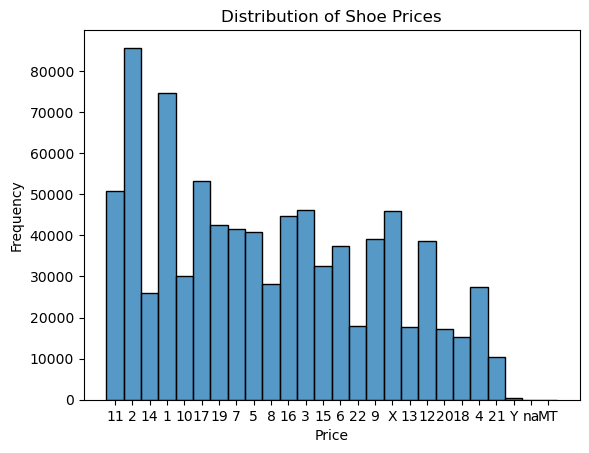

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(data['Chromosome'], bins=40, kde=False)
plt.title('Distribution of Shoe Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [59]:
import re
import numpy as np
import pandas as pd

name_str = data["Name"].astype(str)


is_nonsense_re = re.compile(r"\bp\.[A-Z][a-z]{2}[0-9]+(?:\*|TER|STOP|X)\b", re.I)


syn_patterns = [
    re.compile(r"\bp\.\(?[A-Z][a-z]{2}[0-9]+=\)?", re.I),  
    re.compile(r"\bp\.\(=\)", re.I),                      
    re.compile(r"\bp\.=", re.I),                          
    re.compile(r"\bp\.[A-Z][0-9]+=\b", re.I),           
]

def is_syn_func(s: str) -> int:
    for pat in syn_patterns:
        if pat.search(s):
            return 1
    return 0


is_frameshift_re  = re.compile(r"\bp\.[A-Z][a-z]{2}[0-9]+fs", re.I)


is_missense_re    = re.compile(r"\bp\.[A-Z][a-z]{2}[0-9]+(?!TER|STOP|X)[A-Z][a-z]{2}\b", re.I)
splice_core_re    = re.compile(r"\bc\.\d+[+-][12](?!\d)", re.I)

data["is_nonsense"]   = name_str.str.contains(is_nonsense_re,   regex=True).astype("int8")
data["is_synonymous"] = name_str.apply(is_syn_func).astype("int8")
data["is_frameshift"] = name_str.str.contains(is_frameshift_re, regex=True).astype("int8")
data["is_splice_core"] = name_str.str.contains(splice_core_re, regex=True).astype("int8")
data["is_missense"] = (
    name_str.str.contains(is_missense_re, regex=True)
    & (data["is_nonsense"]==0)
    & (data["is_synonymous"]==0)
    & (data["is_frameshift"]==0)
).astype("int8")


def _snv_pair_row(r):
    if r.get("is_snv", 0)==1 and isinstance(r.get("ReferenceAllele"), str) and isinstance(r.get("AlternateAllele"), str):
        return f'{r["ReferenceAllele"]}>{r["AlternateAllele"]}'
    return "NA"
data["snv_pair"] = data.apply(_snv_pair_row, axis=1).astype("string")

transitions = {("A","G"),("G","A"),("C","T"),("T","C")}
def _is_transition_row(r):
    if r.get("is_snv",0)==1:
        return int((r["ReferenceAllele"], r["AlternateAllele"]) in transitions)
    return 0
data["is_transition"] = data.apply(_is_transition_row, axis=1).astype("int8")


print("synonymous==1 :", int(data["is_synonymous"].sum()))
print("nonsense==1   :", int(data["is_nonsense"].sum()))
print("missense==1   :", int(data["is_missense"].sum()))
print("is_frameshift==1   :", int(data["is_frameshift"].sum()))
print("is_transition==1   :", int(data["is_transition"].sum()))
print("is_splice_core==1   :", int(data["is_splice_core"].sum()))

synonymous==1 : 300438
nonsense==1   : 117872
missense==1   : 179775
is_frameshift==1   : 40
is_transition==1   : 0


In [61]:
prot_flags = ["is_missense","is_synonymous","is_nonsense","is_frameshift"]
overlaps = data[prot_flags].sum(axis=1)
print("rows with >1 protein-effect flag:", int((overlaps > 1).sum()))


print(data.groupby(prot_flags).size().sort_values(ascending=False).head(8))


rows with >1 protein-effect flag: 0
is_missense  is_synonymous  is_nonsense  is_frameshift
0            1              0            0                300438
             0              0            0                266099
1            0              0            0                179775
0            0              1            0                117872
                            0            1                    40
dtype: int64


In [63]:

valid = {"A","C","G","T"}
mask_snv = (
    data["ReferenceAllele"].isin(valid) &
    data["AlternateAllele"].isin(valid) &
    (data["ReferenceAllele"].str.len() == 1) &
    (data["AlternateAllele"].str.len() == 1)
)

kept = int(mask_snv.sum()); dropped = int(len(data) - kept)
data = data.loc[mask_snv].reset_index(drop=True)
print(f"Kept {kept:,} SNVs; dropped {dropped:,} non-SNV/invalid rows.")


data["snv_pair"] = (data["ReferenceAllele"].str.upper() + ">" + data["AlternateAllele"].str.upper()).astype("string")
transition_pairs = {"A>G","G>A","C>T","T>C"}
data["is_transition"] = data["snv_pair"].isin(transition_pairs).astype("int8")

print("is_transition==1:", int(data["is_transition"].sum()))
print(data["snv_pair"].value_counts().head(12))


Kept 863,494 SNVs; dropped 0 non-SNV/invalid rows.
is_transition==1: 571073
C>T    215561
G>A    181841
T>C     87685
A>G     85986
G>T     62059
C>G     45601
C>A     42803
G>C     42244
T>G     28763
T>A     24895
A>T     24222
A>C     21834
Name: snv_pair, dtype: Int64


In [64]:
drop_cols = ["is_snv","is_mnv","is_del","is_ins","indel_len","ref_len","alt_len","Type","OriginSimple"]
for c in drop_cols:
    if c in data.columns: data.drop(columns=c, inplace=True)


In [65]:

print(data.info())


print(data.describe())


print(data.columns)


print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863494 entries, 0 to 863493
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Name             863494 non-null  object
 1   Chromosome       863494 non-null  object
 2   ReferenceAllele  863494 non-null  object
 3   AlternateAllele  863494 non-null  object
 4   y                863494 non-null  int64 
 5   is_transition    863494 non-null  int8  
 6   is_missense      863494 non-null  int8  
 7   is_synonymous    863494 non-null  int8  
 8   is_nonsense      863494 non-null  int8  
 9   is_splice_core   863494 non-null  int8  
 10  snv_pair         863494 non-null  string
 11  is_frameshift    863494 non-null  int8  
dtypes: int64(1), int8(6), object(4), string(1)
memory usage: 44.5+ MB
None
                   y  is_transition    is_missense  is_synonymous  \
count  863494.000000  863494.000000  863494.000000  863494.000000   
mean        0.361429       0.66

In [66]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder  
from pandas.api.types import is_numeric_dtype
import joblib

label_encoder = LabelEncoder()

data['AlternateAllele'] = label_encoder.fit_transform(data['AlternateAllele'])
data['Chromosome'] = label_encoder.fit_transform(data['Chromosome'])
data['ReferenceAllele'] = label_encoder.fit_transform(data['ReferenceAllele'])
data['snv_pair'] = label_encoder.fit_transform(data['snv_pair'])


X = data.drop(columns=["y", "Name"], errors="ignore").copy()
y = data["y"].astype("float32").values


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, shuffle=True)


cat_cols = [c for c in X_train.columns if not is_numeric_dtype(X_train[c])]
num_cols = [c for c in X_train.columns if c not in cat_cols]


preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.float32), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)


X_train_np = preprocess.fit_transform(X_train).astype("float32")
X_val_np   = preprocess.transform(X_val).astype("float32")
X_test_np  = preprocess.transform(X_test).astype("float32")


joblib.dump(preprocess, "preprocess.joblib")





['preprocess.joblib']

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam  
from keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def create_mlp(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid', name='p')  
    ])
    model.compile(
        optimizer=Adam(1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
            tf.keras.metrics.AUC(curve='ROC', name='auc'),
            tf.keras.metrics.AUC(curve='PR',  name='pr_auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model
    
mlp_model = create_mlp(X_train.shape[1])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1),
]

history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=2048,   
    callbacks=callbacks,
    verbose=1
)

scores = mlp_model.evaluate(X_test, y_test, verbose=0, return_dict=True)


print(scores)

print(
    f"Test -> loss={scores['loss']:.4f}, "
    f"acc={scores['acc']:.4f}, auc={scores['auc']:.4f}, "
    f"pr_auc={scores['pr_auc']:.4f}, precision={scores['precision']:.4f}, recall={scores['recall']:.4f}"
)



Epoch 1/1000
296/296 [==============================] - 4s 9ms/step - loss: 0.4174 - acc: 0.8041 - auc: 0.9047 - pr_auc: 0.8441 - precision: 0.8394 - recall: 0.5661 - val_loss: 0.1978 - val_acc: 0.9163 - val_auc: 0.9736 - val_pr_auc: 0.9572 - val_precision: 0.8349 - val_recall: 0.9574 - lr: 1.0000e-04
Epoch 2/1000
296/296 [==============================] - 2s 7ms/step - loss: 0.1856 - acc: 0.9175 - auc: 0.9742 - pr_auc: 0.9586 - precision: 0.8376 - recall: 0.9571 - val_loss: 0.1827 - val_acc: 0.9169 - val_auc: 0.9749 - val_pr_auc: 0.9600 - val_precision: 0.8302 - val_recall: 0.9678 - lr: 1.0000e-04
Epoch 3/1000
296/296 [==============================] - 2s 6ms/step - loss: 0.1794 - acc: 0.9177 - auc: 0.9750 - pr_auc: 0.9600 - precision: 0.8390 - recall: 0.9553 - val_loss: 0.1789 - val_acc: 0.9176 - val_auc: 0.9756 - val_pr_auc: 0.9608 - val_precision: 0.8400 - val_recall: 0.9534 - lr: 1.0000e-04
Epoch 4/1000
296/296 [==============================] - 2s 6ms/step - loss: 0.1778 - acc: 0

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863494 entries, 0 to 863493
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Name             863494 non-null  object
 1   Chromosome       863494 non-null  int32 
 2   ReferenceAllele  863494 non-null  int32 
 3   AlternateAllele  863494 non-null  int32 
 4   y                863494 non-null  int64 
 5   is_transition    863494 non-null  int8  
 6   is_missense      863494 non-null  int8  
 7   is_synonymous    863494 non-null  int8  
 8   is_nonsense      863494 non-null  int8  
 9   is_splice_core   863494 non-null  int8  
 10  snv_pair         863494 non-null  int32 
 11  is_frameshift    863494 non-null  int8  
dtypes: int32(4), int64(1), int8(6), object(1)
memory usage: 31.3+ MB


In [83]:
data.head(10)

,Name,Chromosome,ReferenceAllele,AlternateAllele,y,is_transition,is_missense,is_synonymous,is_nonsense,is_splice_core,snv_pair,is_frameshift
0,NM_002645.4(PIK3C2A):c.1721T>C (p.Val574Ala),2,3,1,0,1,1,0,0,0,10,0
1,NM_004082.5(DCTN1):c.2754C>T (p.Pro918=),11,1,3,0,1,0,1,0,0,5,0
2,NM_017799.4(TMEM260):c.2036C>T (p.Pro679Leu),5,1,3,0,1,1,0,0,0,5,0
3,NM_000085.5(CLCNKB):c.1846-1G>A,0,2,0,1,1,0,0,0,1,6,0
4,NM_000188.3(HK1):c.375+15C>T,1,1,3,0,1,0,0,0,0,5,0
5,NM_001042492.3(NF1):c.4892T>G (p.Leu1631Ter),8,3,2,1,0,0,0,1,0,11,0
6,NM_021250.4(LILRA5):c.55G>A (p.Val19Met),10,2,0,0,1,1,0,0,0,6,0
7,NM_003985.6(TNK1):c.1299G>A (p.Ser433=),8,2,0,0,1,0,1,0,0,6,0
8,NM_001277115.2(DNAH11):c.11352C>T (p.Phe3784=),19,1,3,0,1,0,1,0,0,5,0
9,NM_001267550.2(TTN):c.79162G>T (p.Gly26388Ter),11,2,3,1,0,0,0,1,0,8,0


In [89]:
# --- save to file ---
data.to_csv("clinvar_final_cleaned_for_DL2.tsv", sep="\t", index=False)
print("✅ Wrote balanced sample ")

✅ Wrote balanced sample 


In [33]:
data.to_excel('C:/Users/tahas/clinvar_final_cleaned_for_DL.xlsx', index=False)

In [37]:
from sklearn.preprocessing import MinMaxScaler

# حدد الأعمدة الرقمية (ما عدا Name لأنه نصي)
numeric_cols = data.select_dtypes(include=["int32", "int64", "int8"]).columns

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [88]:
data.head(10)

,Name,Chromosome,ReferenceAllele,AlternateAllele,y,is_transition,is_missense,is_synonymous,is_nonsense,is_splice_core,snv_pair,is_frameshift
0,NM_002645.4(PIK3C2A):c.1721T>C (p.Val574Ala),2,3,1,0,1,1,0,0,0,10,0
1,NM_004082.5(DCTN1):c.2754C>T (p.Pro918=),11,1,3,0,1,0,1,0,0,5,0
2,NM_017799.4(TMEM260):c.2036C>T (p.Pro679Leu),5,1,3,0,1,1,0,0,0,5,0
3,NM_000085.5(CLCNKB):c.1846-1G>A,0,2,0,1,1,0,0,0,1,6,0
4,NM_000188.3(HK1):c.375+15C>T,1,1,3,0,1,0,0,0,0,5,0
5,NM_001042492.3(NF1):c.4892T>G (p.Leu1631Ter),8,3,2,1,0,0,0,1,0,11,0
6,NM_021250.4(LILRA5):c.55G>A (p.Val19Met),10,2,0,0,1,1,0,0,0,6,0
7,NM_003985.6(TNK1):c.1299G>A (p.Ser433=),8,2,0,0,1,0,1,0,0,6,0
8,NM_001277115.2(DNAH11):c.11352C>T (p.Phe3784=),19,1,3,0,1,0,1,0,0,5,0
9,NM_001267550.2(TTN):c.79162G>T (p.Gly26388Ter),11,2,3,1,0,0,0,1,0,8,0


In [72]:
import numpy as np
import matplotlib.pyplot as plt

ignore_epochs = 1
hist = history.history

epochs = np.arange(ignore_epochs, len(hist['loss']))
training_loss   = np.array(hist['loss'][ignore_epochs:])
validation_loss = np.array(hist['val_loss'][ignore_epochs:])
training_r2     = np.array(hist['r_squared'][ignore_epochs:])
validation_r2   = np.array(hist['val_r_squared'][ignore_epochs:])

# Get test metrics (use existing vars if they exist; otherwise evaluate now)
try:
    test_loss_val = float(test_loss)
except Exception:
    test_loss_val = mlp_model.evaluate(X_test, y_test, verbose=0)[0]

try:
    test_r2_val = float(test_r_squared)
except Exception:
    # metrics order: [loss, mae, mse, r_squared]
    test_r2_val = mlp_model.evaluate(X_test, y_test, verbose=0)[-1]

# ---- Loss ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.axhline(test_loss_val, linestyle='--', linewidth=1.5,
            label=f'Test Loss = {test_loss_val:.4f}')
plt.title('Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()

# ---- R-squared ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_r2, label='Training R-squared')
plt.plot(epochs, validation_r2, label='Validation R-squared')
plt.axhline(test_r2_val, linestyle='--', linewidth=1.5,
            label=f'Test R-squared = {test_r2_val:.4f}')
plt.title('R-squared')
plt.xlabel('Epochs'); plt.ylabel('R-squared')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()


KeyError: 'r_squared'

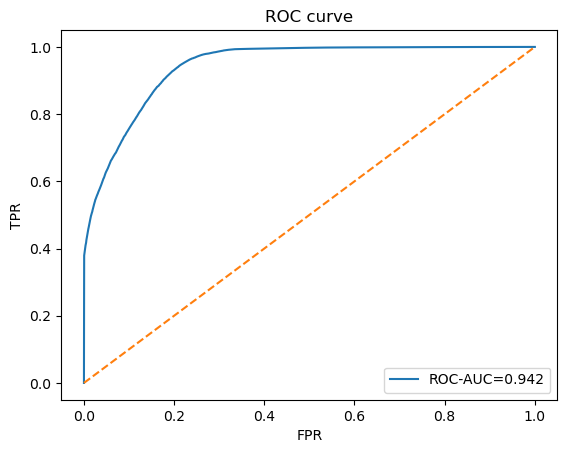

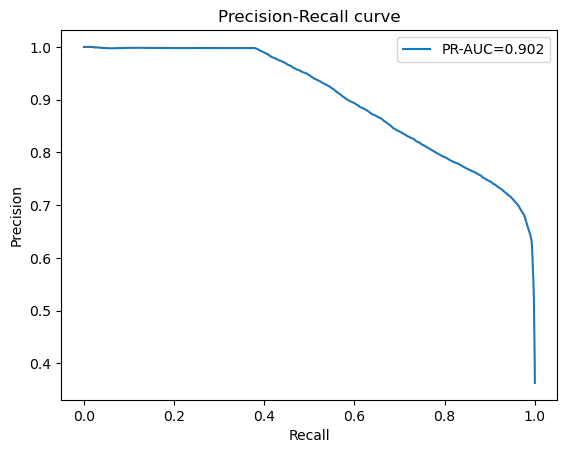

In [73]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC-AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC curve')
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f'PR-AUC={ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.title('Precision-Recall curve')
plt.show()


C:\Users\tahas\anaconda3\envs\neural_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


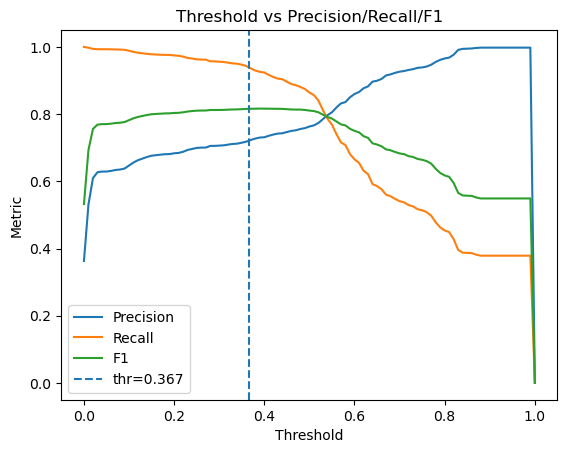

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score

ths = np.linspace(0, 1, 101)
P, R, F1 = [], [], []
for t in ths:
    y_h = (y_proba >= t).astype(int)
    P.append(precision_score(y_test, y_h))
    R.append(recall_score(y_test, y_h))
    F1.append(f1_score(y_test, y_h))

plt.figure()
plt.plot(ths, P, label='Precision')
plt.plot(ths, R, label='Recall')
plt.plot(ths, F1, label='F1')
plt.axvline(thr, linestyle='--', label=f'thr={thr}')
plt.xlabel('Threshold'); plt.ylabel('Metric'); plt.legend()
plt.title('Threshold vs Precision/Recall/F1')
plt.show()


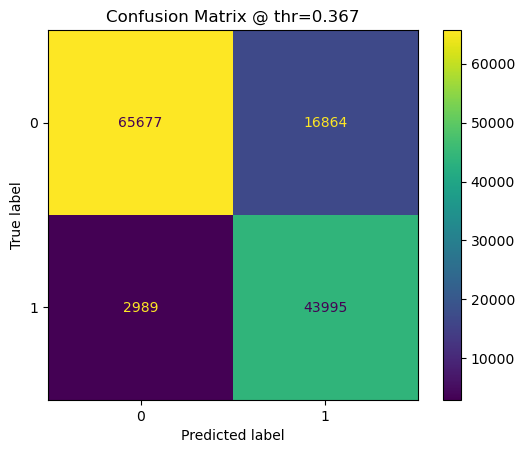

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d'); plt.title(f'Confusion Matrix @ thr={thr}')
plt.show()


32/32 [==============================] - 0s 3ms/step
[VAL] best_epoch=90  best_val_loss=0.175915
[TEST] thr=0.452  ACC=0.9193  F1=0.8973  PREC=0.8333  REC=0.9721  ROC-AUC=0.9774  PR-AUC=0.9633  Brier=0.0536
Confusion matrix:
 [[73405  9136]
 [ 1313 45671]]


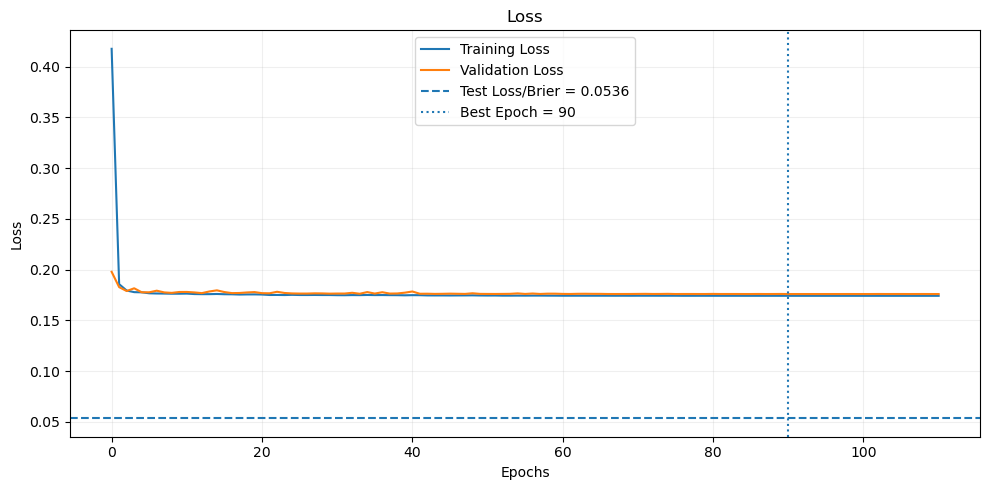

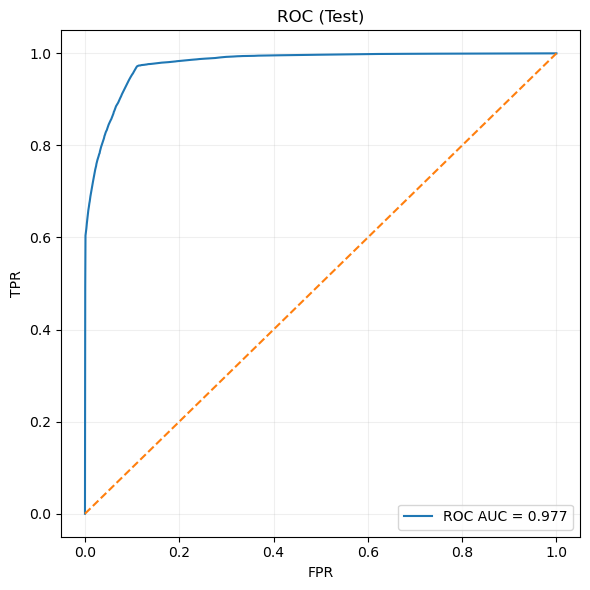

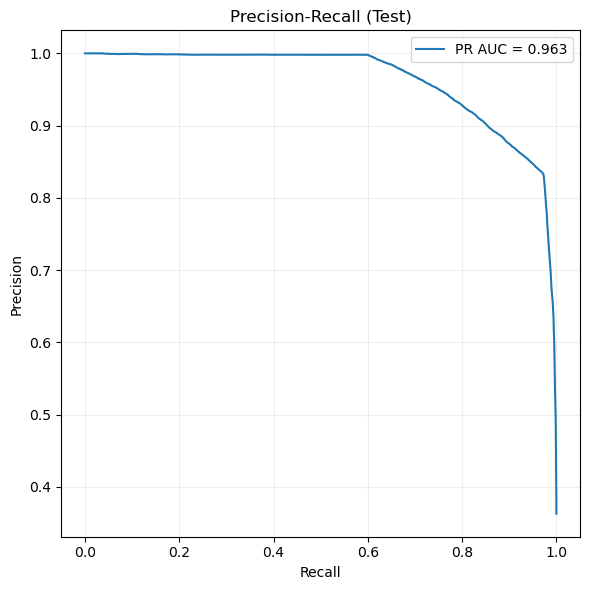

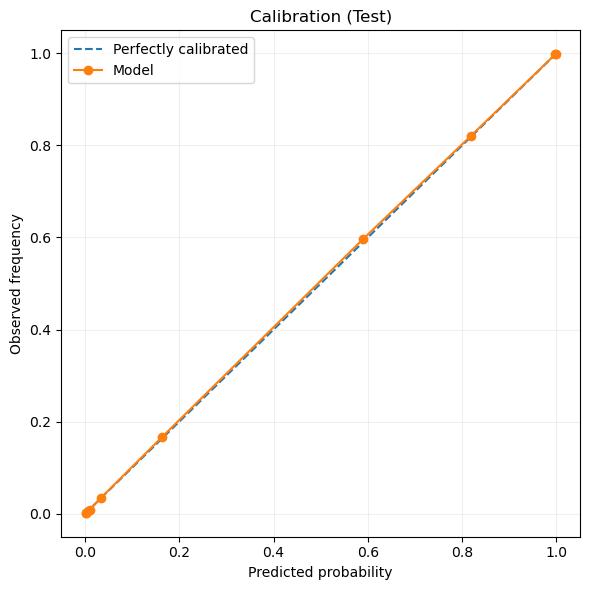

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, r2_score
)
from sklearn.calibration import calibration_curve

# ---- get history arrays ----
hist = history.history
epochs = np.arange(len(hist['loss']))

best_epoch = int(np.argmin(hist['val_loss']))
best_val_loss = float(hist['val_loss'][best_epoch])

# ---- predictions ----
y_val_pred  = mlp_model.predict(X_val,  batch_size=4096).squeeze()
y_test_pred = mlp_model.predict(X_test, batch_size=4096).squeeze()

# clip to [0,1] since الخرج linear لمهمة ثنائية
y_val_prob  = np.clip(y_val_pred,  0.0, 1.0)
y_test_prob = np.clip(y_test_pred, 0.0, 1.0)

# ---- choose threshold on validation (Youden J) ----
fpr, tpr, thr = roc_curve(y_val, y_val_prob)
ix = np.argmax(tpr - fpr)
best_thr = float(thr[ix])

# ---- test metrics at best_thr ----
y_test_hat = (y_test_prob >= best_thr).astype(int)
test_acc = accuracy_score(y_test, y_test_hat)
test_prec = precision_score(y_test, y_test_hat)
test_rec  = recall_score(y_test, y_test_hat)
test_f1   = f1_score(y_test, y_test_hat)
test_cm   = confusion_matrix(y_test, y_test_hat)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_pr_auc  = average_precision_score(y_test, y_test_prob)
test_brier   = brier_score_loss(y_test, y_test_prob)  # ≡ MSE للثنائي

print(f"[VAL] best_epoch={best_epoch}  best_val_loss={best_val_loss:.6f}")
print(f"[TEST] thr={best_thr:.3f}  ACC={test_acc:.4f}  F1={test_f1:.4f}  "
      f"PREC={test_prec:.4f}  REC={test_rec:.4f}  ROC-AUC={test_roc_auc:.4f}  PR-AUC={test_pr_auc:.4f}  Brier={test_brier:.4f}")
print("Confusion matrix:\n", test_cm)

# ---- Plot Loss with best epoch + test line ----
plt.figure(figsize=(10,5))
plt.plot(epochs, hist['loss'], label='Training Loss')
plt.plot(epochs, hist['val_loss'], label='Validation Loss')
plt.axhline(test_brier, ls='--', lw=1.5, label=f'Test Loss/Brier = {test_brier:.4f}')
plt.axvline(best_epoch, ls=':', lw=1.5, label=f'Best Epoch = {best_epoch}')
plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()

# ---- R^2 curves + best epoch ----
if 'r_squared' in hist and 'val_r_squared' in hist:
    plt.figure(figsize=(10,5))
    plt.plot(epochs, hist['r_squared'], label='Training R-squared')
    plt.plot(epochs, hist['val_r_squared'], label='Validation R-squared')
    # احسب R^2 على الاختبار (تحقق إضافي)
    test_r2 = r2_score(y_test, y_test_pred)
    plt.axhline(test_r2, ls='--', lw=1.5, label=f'Test R-squared = {test_r2:.4f}')
    plt.axvline(best_epoch, ls=':', lw=1.5, label=f'Best Epoch = {best_epoch}')
    plt.title('R-squared'); plt.xlabel('Epochs'); plt.ylabel('R-squared')
    plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
    plt.show()

# ---- ROC & PR on TEST ----
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)
prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr_t, tpr_t, label=f'ROC AUC = {test_roc_auc:.3f}')
plt.plot([0,1],[0,1], ls='--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Test)')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(rec_t, prec_t, label=f'PR AUC = {test_pr_auc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (Test)')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()

# ---- Calibration curve (Test) ----
prob_true, prob_pred = calibration_curve(y_test, y_test_prob, n_bins=10, strategy='quantile')
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], ls='--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Calibration (Test)')
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.show()


In [85]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, matthews_corrcoef

# 1) Get probabilities/predictions from your model
probs = mlp_model.predict(X_test, verbose=0).ravel()   # shape (n,)
thr = 0.367
y_pred = (probs >= thr).astype(int)                    # binarize for metrics

# 2) One-line full report (includes precision, recall, f1-score, support)
print(classification_report(
    y_test, y_pred,
    target_names=["Negative","Positive"],  # optional
    digits=4
))

# 3) If you need the numbers programmatically (as a dict):
report = classification_report(y_test, y_pred, output_dict=True)
# e.g. report['Positive']['f1-score'], report['accuracy'], report['macro avg']['f1-score']

# 4) Common individual metrics
acc  = accuracy_score(y_test, y_pred)
f1_w = f1_score(y_test, y_pred, average='weighted')  # 'binary'/'macro'/'micro'/'weighted'
f1_b = f1_score(y_test, y_pred, average='binary')

# 5) Confusion matrix + derived stats (specificity, etc.)
import numpy as np
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
npv = tn / (tn + fn)
mcc = matthews_corrcoef(y_test, y_pred)

# 6) Metrics that need probabilities (not hard labels)
roc_auc = roc_auc_score(y_test, probs)
pr_auc  = average_precision_score(y_test, probs)
brier   = brier_score_loss(y_test, probs)

print({
    "accuracy": acc,
    "f1_binary": f1_b,
    "f1_weighted": f1_w,
    "specificity": specificity,
    "NPV": npv,
    "MCC": mcc,
    "ROC_AUC": roc_auc,
    "PR_AUC": pr_auc,
    "Brier": brier
})


              precision    recall  f1-score   support

    Negative     0.9824    0.8893    0.9336     82541
    Positive     0.8333    0.9721    0.8973     46984

    accuracy                         0.9193    129525
   macro avg     0.9079    0.9307    0.9155    129525
weighted avg     0.9283    0.9193    0.9204    129525

{'accuracy': 0.9193283149971048, 'f1_binary': 0.8973484885697164, 'f1_weighted': 0.9204217225740413, 'specificity': 0.8893156128469488, 'NPV': 0.9824272598302952, 'MCC': 0.8382410570670856, 'ROC_AUC': 0.9774211660968315, 'PR_AUC': 0.9633404109391658, 'Brier': 0.0535798235178482}


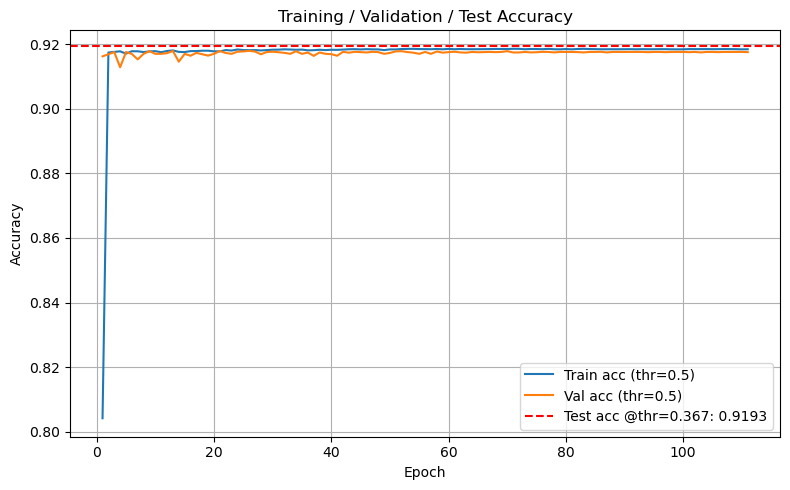

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# 1) Training & Validation accuracy curves from history
train_acc = history.history.get('acc')
val_acc   = history.history.get('val_acc')
epochs    = range(1, len(train_acc) + 1)

# 2) Test accuracy (at chosen threshold)
probs = mlp_model.predict(X_test, verbose=0).ravel()
thr = 0.367
y_pred_thr = (probs >= thr).astype(int)
acc_test_thr = accuracy_score(y_test, y_pred_thr)

# 3) Plot all together
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train acc (thr=0.5)")
plt.plot(epochs, val_acc,   label="Val acc (thr=0.5)")
plt.axhline(y=acc_test_thr, color='r', linestyle='--',
            label=f"Test acc @thr={thr}: {acc_test_thr:.4f}")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training / Validation / Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


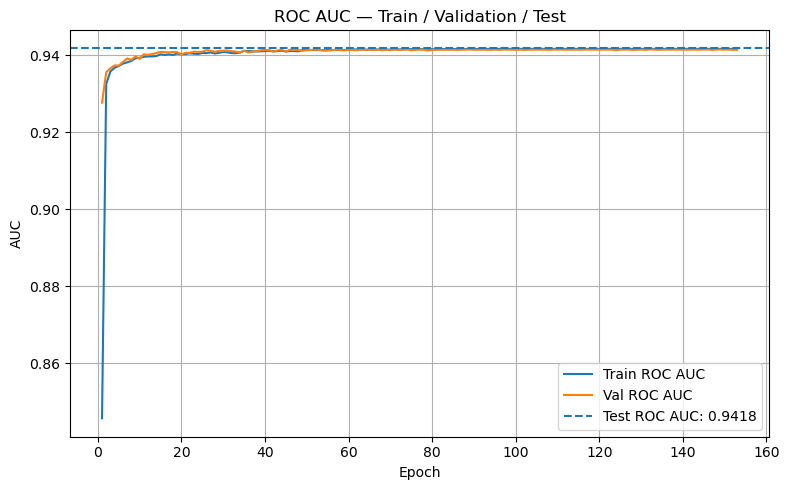

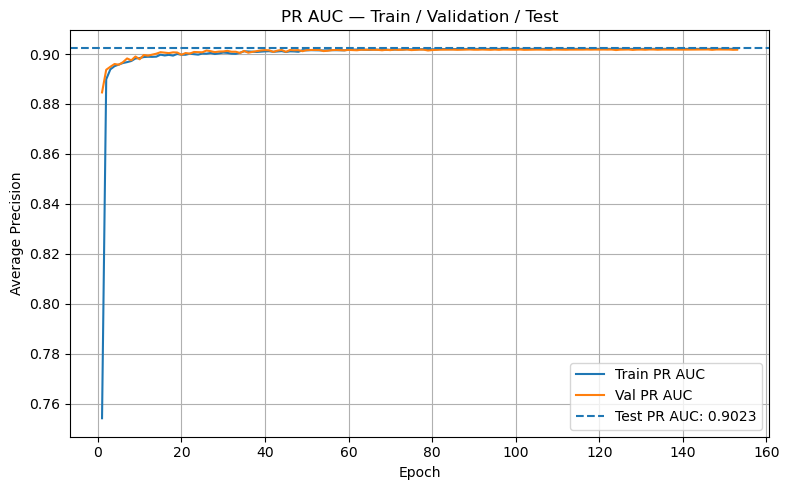

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

# ---- 1) Get test probabilities safely ----
probs = mlp_model.predict(X_test, verbose=0).ravel()
if probs.min() < 0 or probs.max() > 1:
    probs = 1.0 / (1.0 + np.exp(-probs))  # sigmoid for logits
probs = np.clip(probs, 1e-7, 1-1e-7)

# ---- 2) Compute test AUCs ----
test_roc_auc = roc_auc_score(y_test, probs)
test_pr_auc  = average_precision_score(y_test, probs)  # PR AUC (Average Precision)

# ---- 3) Pull train/val curves from history ----
hist = history.history if hasattr(history, 'history') else history
train_roc = hist.get('auc')
val_roc   = hist.get('val_auc')
train_pr  = hist.get('pr_auc')
val_pr    = hist.get('val_pr_auc')

# ---- 4) Plot ROC AUC ----
if train_roc is not None and val_roc is not None:
    epochs = range(1, len(train_roc) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_roc, label="Train ROC AUC")
    plt.plot(epochs, val_roc,   label="Val ROC AUC")
    plt.axhline(test_roc_auc, linestyle='--',
                label=f"Test ROC AUC: {test_roc_auc:.4f}")
    plt.xlabel("Epoch"); plt.ylabel("AUC")
    plt.title("ROC AUC — Train / Validation / Test")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
else:
    print("⚠️ ROC AUC keys not found in history (expected 'auc' and 'val_auc').")

# ---- 5) Plot PR AUC ----
if train_pr is not None and val_pr is not None:
    epochs = range(1, len(train_pr) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_pr, label="Train PR AUC")
    plt.plot(epochs, val_pr,   label="Val PR AUC")
    plt.axhline(test_pr_auc, linestyle='--',
                label=f"Test PR AUC: {test_pr_auc:.4f}")
    plt.xlabel("Epoch"); plt.ylabel("Average Precision")
    plt.title("PR AUC — Train / Validation / Test")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()
else:
    print("⚠️ PR AUC keys not found in history (expected 'pr_auc' and 'val_pr_auc').")
